

---

<center>
<h1>
Text Mining and Search Project

by L.Mauri, A.Vincenzi, E.Rebesco

</h1>
</center>


---



# Download pkgs addizionali

In [ ]:
!pip install nlpaug
!pip install demoji
!pip install regex
!pip install unidecode
!pip install stop-words

#Import pacchetti/librerie

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import string
from unidecode import unidecode
import demoji
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from textblob import Word
import regex as re

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import  GridSearchCV

In [ ]:
import keras 
from keras import layers
from keras.models import Sequential
from tensorflow.keras import initializers

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from pandas._typing import FilePathOrBuffer

In [ ]:
import nlpaug.augmenter.word as naw

In [ ]:
from stop_words import get_stop_words
from nltk.corpus import stopwords 
from nltk.tokenize import TweetTokenizer

In [ ]:
from sklearn.utils import shuffle

In [ ]:
from typing import Any, AnyStr, List, Dict

In [ ]:
from tqdm import tqdm
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Download Risorse


---



In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
porter = PorterStemmer()
punctuation = string.punctuation
lang = ['english']
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
demoji.download_codes()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
... OK (Got response in 0.15 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


# Funzioni



---



In [ ]:
# cleaners
def clean_remove_tags_hashtags(text: str, inplace: bool = False) -> str:
    return re.sub(r'@[a-zA-z]+|#[a-zA-z]+', '', text)

def clean_remove_tags_hashtags(text: str, inplace: bool = False) -> str:
    text = ' '.join(text)
    return re.sub(r'@[a-zA-z]+|#[a-zA-z]+', '', text)

def clean_space_normalizer(text: str) -> str:
    return re.sub(r'\s\s+', r' ', text)

def clean_remove_punkt(text: str) -> str:
    return text.translate(str.maketrans('', '', punctuation))

def clean_remove_emoji(text: str) -> str:
    return demoji.replace(text)

def clean_remove_residuals(text: str) -> str:
    return ''.join([c for c in text if ord(c) < 128])

def clean_remove_repetition(text: str) -> str:
    return re.sub('(.)(?<=\\1\\1)', '', text)

def clean_capital_sequences(text: str) -> str:
    return re.sub('\b[A-Z]{2,3}\b', ' ', text)

def clean_space_condenser(text: str) -> str:
    _pattern = [
        re.compile(_r) for _r in
        [r'\s{2,}', r'^\s+|\s+$', r'\s+', r'(?:(?!\w+)\s?[\/]+\s?(?!\w+))']
    ]
    _subs = [r' ', r'', r' ', r' ']

    for r, s in zip(_pattern, _subs):
        text = r.sub(s, text)
    return unidecode(text.lower())

def clean_remove_digit(text: str) -> str:
    return re.sub(r'\d+', '', text)
  
def clean_url(text: str) -> str:
    return re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.M)

In [ ]:
# get enhanced stopwords
stop_words = list(set(stopwords.words('english') + get_stop_words('english')))

In [ ]:
# get tokens
def tokenizer(text, tt: TweetTokenizer, stop_words: List) -> List:
    return [w.lower() for w in [
        re.sub(r'\b\w{1,2}\b', '', w) for w in tt.tokenize(text)
        if not w in stop_words  
    ] if w]

In [ ]:
def stemText(text):
  return  ' '.join([porter.stem(word) for word in tt.tokenize(text)])

def setLabels(text):
  return 2 if text == 'positive' else (1 if  text == 'neutral' else 0)


def underSampling(dataframe,n=100,classesCol='airline_sentiment_labels'):
  class_pos = dataframe[dataframe[classesCol] == 2 ].sample(n)
  class_neg = dataframe[dataframe[classesCol] == 0 ].sample(n)
  class_neu = dataframe[dataframe[classesCol] == 1 ].sample(n)
  return class_pos, class_neg, class_neu

def lemmatize(x):
  """
  :param x: list of tokens 
  :param type: list
  """
  w = Word(x)
  return w.lemmatize()

def plotClassesFrequency(dataframe,plotDim,column):
  plt.figure(figsize=plotDim)
  sns.countplot(dataframe[column],palette='coolwarm')
  plt.xlabel('classi',size=14)
  plt.ylabel('frequenza',size=14)


# Import dati



---



In [ ]:
filePath = '/content/drive/MyDrive/text mining and search/twitter sentiment/Tweets.csv'
twitterReviews = pd.read_csv(filePath)
twitterReviews.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [ ]:
twitterReviews= twitterReviews[['text','airline_sentiment']]
twitterReviews.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [ ]:
twitterReviews.isnull().sum()

text                 0
airline_sentiment    0
dtype: int64

# Preprocessing


---


* Tokenizzazione

* Rimozione dei tag e hashtag ( @abc e #abc )

* Rimozione degli url

* Rimozione delle stopwords 

* Rimozione della punteggiatura 

* Rimozione dei numeri 

* Rimozione degli spazi bianchi



* **Data Augmentation**

* Lemmatizzazione

* Stemming

* Codifica della variabile target

* Rimozione delle recensioni vuote



### Tokenizzazione



---



In [ ]:
tt = TweetTokenizer()
twitterReviews['transformed_text']= twitterReviews.text.progress_apply(tokenizer, args=(tt, stop_words))

100%|██████████| 14640/14640 [00:02<00:00, 5039.00it/s]


In [ ]:
twitterReviews.head(3)

,text,airline_sentiment,transformed_text
0,@VirginAmerica What @dhepburn said.,neutral,"[@virginamerica, what, @dhepburn, said, .]"
1,@VirginAmerica plus you've added commercials t...,positive,"[@virginamerica, plus, added, commercials, exp..."
2,@VirginAmerica I didn't today... Must mean I n...,neutral,"[@virginamerica, today, ..., must, mean, need,..."


### Sanitize raw text


---



In [ ]:
# hashtag and tags
twitterReviews['transformed_text'] = twitterReviews.transformed_text.apply(
    clean_remove_tags_hashtags)

# URL
twitterReviews[
    'transformed_text'] = twitterReviews.transformed_text.apply(
        clean_url)

# space normalizer
twitterReviews[
    'transformed_text'] = twitterReviews.transformed_text.apply(
        clean_space_normalizer)
  
# punctuation
twitterReviews[
    'transformed_text'] = twitterReviews.transformed_text.apply(
        clean_remove_punkt)
    
# emoji
twitterReviews[
    'transformed_text'] = twitterReviews.transformed_text.apply(
        clean_remove_emoji)
    
# residual symbold
twitterReviews[
    'transformed_text'] = twitterReviews.transformed_text.apply(
        clean_remove_residuals)
    
# repetitive pattern SKIPPED NOT IN USE
# twitterReviews[
#   'transformed_text'] = twitterReviews.transformed_text.apply(
#    clean_remove_repetition) 

# remove all digits [0-9]
twitterReviews[
    'transformed_text'] = twitterReviews.transformed_text.apply(
        clean_remove_digit)
    
# remove capital sequences
twitterReviews[
    'transformed_text'] = twitterReviews.transformed_text.apply(
        clean_capital_sequences)

# space condensation    
twitterReviews[
    'transformed_text'] = twitterReviews.transformed_text.apply(
        clean_space_condenser)

In [ ]:
twitterReviews.head(3)

,text,airline_sentiment,transformed_text
0,@VirginAmerica What @dhepburn said.,neutral,what said
1,@VirginAmerica plus you've added commercials t...,positive,plus added commercials experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,neutral,today must mean need take another trip


In [ ]:
twitterReviews.shape

(14640, 3)

### Codifica della variabile target


---







* positivo : 2 
* neutro : 1
* negativo : 0





In [ ]:
twitterReviews['airline_sentiment_labels'] = twitterReviews.airline_sentiment.apply(setLabels)

In [ ]:
twitterReviews.head()

,text,airline_sentiment,transformed_text,airline_sentiment_labels
0,@VirginAmerica What @dhepburn said.,neutral,what said,1
1,@VirginAmerica plus you've added commercials t...,positive,plus added commercials experience tacky,2
2,@VirginAmerica I didn't today... Must mean I n...,neutral,today must mean need take another trip,1
3,@VirginAmerica it's really aggressive to blast...,negative,really aggressive blast obnoxious entertainmen...,0
4,@VirginAmerica and it's a really big bad thing...,negative,really big bad thing,0


### Data Augmentation


---


* Creiamo una copia del dataframe per vedere effettivamente le differenze con il dataset senza augmentation e quello con augmentation

In [ ]:
twitterReviews_noAug = twitterReviews.copy()

In [ ]:
FIELDS: Dict[str, Any] = dict(positive=4, neutral=3, negative=0)

# Function to upsample the minor classes through data augmentation 
def augment_text(_df_text: DataFrame,
                  _label: str,
                  _replica: int,
                  _samples: int = 100,
                  _aug_p: float = .5,
                  _sentiment_column: str = 'airline_sentiment',
                  _sentiment_labels_column: str = 'airline_sentiment_labels'):
    """
    Generate additional, synthetic data using the data from the original set.
    Return an augmented DataFrame object based on Synonym Replacement. The
    synonym replacement will randomly choose n words from the sentence that
    are not stop words. Replace each of these words with one of its synonyms
    chosen at random. """

    _text = []
    _labels = []
    _labels_class =[]

    # Augmenter that leverage semantic meaning to substitute word.
    augmenter_obj = naw.SynonymAug(aug_p=.5)
    
    # slice the set after safe copy
    _df = _df_text.copy()
    df_n = _df[_df[_sentiment_column] == _label].reset_index(drop=True)

    # loop over the sampled rows :-/
    for i in tqdm(np.random.randint(0, len(df_n), _samples)):
        for _ in np.arange(_replica):
            augmented_text = augmenter_obj.augment(df_n.iloc[i]['transformed_text'])
            _text.append(augmented_text)
            _labels.append(df_n.iloc[i][_sentiment_column])
            _labels_class.append(df_n.iloc[i]['airline_sentiment_labels'])

    # dataframe
    new = pd.DataFrame({
        'transformed_text': _text,
        _sentiment_column: _labels,
        'airline_sentiment_labels' : _labels_class
    })
    _df_text=shuffle(_df_text.append(new).reset_index(drop=True))
    return _df_text

In [ ]:
# Upsample the dataset
for k, v in FIELDS.items():
    twitterReviews = augment_text(_df_text=twitterReviews, _label=k, _replica=v, _samples=300)

100%|██████████| 300/300 [00:00<00:00, 172415.89it/s]


In [ ]:
twitterReviews_noAug.groupby('airline_sentiment_labels').size()  # NOT augmented dataframe

airline_sentiment_labels
0    9178
1    3099
2    2363
dtype: int64

In [ ]:
twitterReviews.groupby('airline_sentiment_labels').size()  # augmented dataframe

airline_sentiment_labels
0.0    9178
1.0    3999
2.0    3563
dtype: int64



---


* Notiamo che sono state generate un totale di **2100** osservazioni artificiali :

 1200 per la classe minoritaria **positiva** (2) e 900 per la classe minoritaria **neutra** (1).






---



### Lemmatizzazione


---



In [ ]:
twitterReviews['transformed_text'] = twitterReviews.transformed_text.apply(lemmatize)
twitterReviews_noAug['transformed_text'] = twitterReviews_noAug.transformed_text.apply(lemmatize)

### Stemming

In [ ]:
twitterReviews['transformed_text'] = twitterReviews.transformed_text.apply(stemText)
twitterReviews_noAug['transformed_text'] = twitterReviews_noAug.transformed_text.apply(stemText)

### Rimozione delle recensioni vuote

In [ ]:
twitterReviews = twitterReviews[twitterReviews.transformed_text !='']
twitterReviews_noAug = twitterReviews_noAug[twitterReviews_noAug.transformed_text !='']

In [ ]:
twitterReviews.head()

,text,airline_sentiment,transformed_text,airline_sentiment_labels
479,@USAirways just an FYI I'll be writing registe...,negative,fyi write regist letter ceo line shame treatme...,0.0
6726,"@AmericanAir to add insult to injury, I have t...",negative,add insult injuri pick real class act stick delta,0.0
8814,@united broke my suitcase &amp; refuses to giv...,negative,broke suitcas refus give repair estim,0.0
780,@united yes when I got to the gate I specifica...,negative,ye got gate specif ask seat veri discourag wal...,0.0
12798,@united lost 4 loyal customers and mileage plu...,negative,lost loyal custom mileag plu card holder drive...,0.0


# Class imbalance


---







Dal momento che, purtroppo, la data augmentation non è sufficiente per bilanciare complessivamente il dataset, ricorriamo anche all'**undersampling**. Cerchiamo ciò di eliminare dalla classe negativa (0) i record in eccesso tramite campionamento casuale semplice.




**Augmented DataFrame**


---


Estraiamo n=3560 record (numerosità della classe minoritaria) dalla classe maggioritaria 


In [ ]:
twitterReviews.groupby('airline_sentiment_labels').size()  # augmented dataframe

airline_sentiment_labels
0.0    9161
1.0    3966
2.0    3560
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


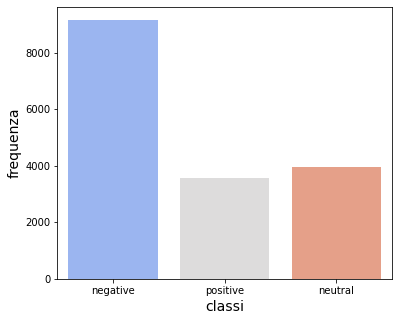

In [ ]:
plotClassesFrequency(plotDim=(6,5),column='airline_sentiment',dataframe=twitterReviews)

In [ ]:
pos,neu,neg = underSampling(twitterReviews,n = 3560)
twitterReviewsBalanced_Aug = pd.concat([pos,neu,neg])

**NOT Augmented Dataframe**


---

Estraiamo n=2360 record (numerosità della classe minoritaria) dalla classe maggioritaria 


In [ ]:
twitterReviews_noAug.groupby('airline_sentiment_labels').size()  # NOT augmented dataframe

airline_sentiment_labels
0    9161
1    3069
2    2360
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


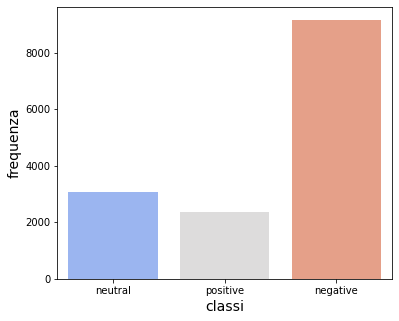

In [ ]:
plotClassesFrequency(plotDim=(6,5),column='airline_sentiment',dataframe=twitterReviews_noAug)

In [ ]:
pos,neu,neg = underSampling(twitterReviews_noAug,n = 2360)
twitterReviewsBalanced_noAug = pd.concat([pos,neu,neg])




---


* Salviamo i due dataset per passare poi alla parte di data modeling 


---



In [ ]:
twitterReviewsBalanced_noAug.to_csv('twitterReviewsBalanced_noAug.csv')

In [ ]:
twitterReviewsBalanced_Aug.to_csv('twitterReviewsBalanced_Aug.csv')